In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

import json
import experiment_parser_extended as exp
import numpy as np

from tqdm import tqdm

import dlib
tqdm.pandas()

2021-11-22 23:46:47.100534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'masker': <class 'callbacks.permutation_callbacks.Masker'>, 'pdrop_out': <class 'callbacks.permutation_callbacks.PermutationDropOut'>, 'schedule_lr': <class 'callbacks.schedulers.LearningRateScheduler'>, 'schedule_wd': <class 'callbacks.schedulers.WeightDecayScheduler'>, 'schedule_adamw': <class 'callbacks.schedulers.AdamWScheduler'>, 'ckpt': <class 'callbacks.checkpoint_callbacks.CheckpointCallback'>}


In [ ]:
"""
print(disfa_labels)
disfa_labels['path'] = disfa_labels.apply(get_dest_frame_from_df, axis=1)
disfa_labels['landmarks'] = disfa_labels.apply(get_dest_landmarks_from_df, axis=1)
disfa_labels['exists'] = disfa_labels['landmarks'].map(lambda x: os.path.exists(x))
disfa_missed_landmarks = disfa_labels[~disfa_labels['exists']]

shape_predictor_path = os.path.join('..', 'resources', 'pretrained_face_predictor', 'shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
landmark_predictor_v1 = landmark_detectorv1(detector, predictor)

disfa_missed_landmarks.progress_apply(get_landmarks_and_save(landmark_predictor_v1), axis=1)
"""

In [27]:
DISFA_PATH = os.path.join('..', 'resources', 'DISFA')
DISFA_LABEL_PATH = os.path.join(DISFA_PATH, 'preprocessed', '160x160', 'folds', 'fold{}.csv')

src_video_template = os.path.join(DISFA_PATH, 'FRAMES', 'SN{:03d}')
dest_video_template = os.path.join(DISFA_PATH, 'preprocessed', '{}', 'images', 'SN{:03d}')
landmark_template = os.path.join(DISFA_PATH, 'preprocessed', 'landmarks', 'SN{:03d}')
bbox_template = os.path.join(DISFA_PATH, 'preprocessed', 'bbox', 'SN{:03d}')

frame_template = 'frame{:04d}'
# landmark_template = os.path.join(DISFA_PATH, 'Landmark_Points','SN{:03d}', 'frame_lm', 'SN{:03d}_{:04d}_lm.mat')


def get_dest_landmarks(video, frame):
    return os.path.join(landmark_template.format(video), frame_template.format(frame) + '.npy')

def get_dest_bbox(video, frame):
    return os.path.join(bbox_template.format(video), frame_template.format(frame) + '.npy')

def get_frame(video, frame):
    return frame_template.format(video, frame)

def get_dest_frame(image_size, video, frame):
    return os.path.join(dest_video_template.format(image_size, video), frame_template.format(frame) + '.jpg')

def format_frame(frame):
    return frame_template.format(frame)

def get_dest_frame_from_df(image_size):
    def fun(x):
        return get_dest_frame(image_size, x['video'], x['frame'])
    return fun
        
def get_dest_landmarks_from_df(x):
    return get_dest_landmarks(x['video'], x['frame'])

def get_dest_bbox_from_df(x):
    return get_dest_bbox(x['video'], x['frame'])
    
def get_video(path):
    return int(path.split('/')[-2][2:])

def get_frame(path):
    return int(os.path.splitext(path.split('/')[-1])[0][5:])

def get_landmarks_and_save(landmark_predictor):
    def fun(x):
        path = x['original_path']
        landmarks_path = x['landmarks']
        image = plt.imread(path)
        if os.path.exists(landmarks_path):
            return True
        isfound, landmarks = landmark_predictor(image)
        if isfound:
            np.save(landmarks_path, landmarks) 
        return isfound
    return fun

def bbox_parse(bbox_path):
    bbox = np.load(bbox_path, allow_pickle=True)
    return bbox
    

def get_original_frame(video, frame):
    return os.path.join(src_video_template.format(video), frame_template.format(frame) + '.jpg')

def get_original_frame_apply(x):
    video = x['video']
    frame = x['frame']
    return get_original_frame(video, frame)

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def landmark_detectorv1(face_detector, landmark_predictor):
    def detect_landmarks(image):
        rects = face_detector(image, 1)
        if len(rects) < 1:
            return False, None 
        rect = rects[0]
        shape = shape_to_np(landmark_predictor(image, rect))
        return True, shape
    return detect_landmarks

def isNone(x):
    return not(x is None)


"""
shape_predictor_path = os.path.join('..', 'resources', 'pretrained_face_predictor', 'shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
# landmark_predictor_v1 = landmark_detectorv1(detector, predictor)
"""

    
disfa_labels = pd.read_csv(os.path.join(DISFA_PATH, 'preprocessed', 'preprocessed_classic.csv'))



disfa_labels['src_path'] = disfa_labels.progress_apply(get_original_frame_apply, axis=1)
disfa_labels['landmarks'] = disfa_labels.apply(get_dest_landmarks_from_df, axis=1)
disfa_labels['dest_path'] = disfa_labels.progress_apply(get_dest_frame_from_df('299x299'), axis=1)
disfa_labels['has_landmarks'] = disfa_labels['landmarks'].map(lambda x: os.path.exists(x))
disfa_labels['bbox'] = disfa_labels.progress_apply(get_dest_bbox_from_df, axis=1)
disfa_labels['bbox_mat'] = disfa_labels['bbox'].map(bbox_parse)


# unpredicted_landmarks = disfa_labels[~disfa_labels['has_landmarks']]
# unpredicted_landmarks.progress_apply(get_landmarks_and_save, axis=1)

100%|████████████████████████████████| 125841/125841 [00:01<00:00, 72428.79it/s]


In [38]:
disfa_labels['has_bbox'] = disfa_labels['bbox_mat'].map(isNone)

In [42]:
def crop_image_with_margin(image, bbox, margin):
    original_size = image.shape
    pad_left = int(np.maximum(bbox[0] - margin/2, 0))
    pad_top = int(np.maximum(bbox[1] - margin/2, 0))
    pad_right = int(np.minimum(bbox[2] + margin/2, original_size[1]))
    pad_bottom = int(np.minimum(bbox[3] + margin/2, original_size[0]))
    return image[pad_top:pad_bottom, pad_left:pad_right, :]

def resized_crop_from_image_with_margin(image, bbox, img_size, margin):
    cropped_img = crop_image_with_margin(image, bbox, margin)
    resized_crop = cv2.resize(cropped_img, (img_size, img_size))
    return resized_crop

def resize_crop_and_save(img_size, margin):
    def fun(x):
        src_img = cv2.imread(x['src_path'])
        dest_path = x['dest_path']
        bbox = np.load(x['bbox'])
        dest_img = resized_crop_from_image_with_margin(src_img, bbox, img_size, margin)
        cv2.imwrite(dest_path, dest_img)
    return fun


In [43]:
disfa_labels.loc[disfa_labels['has_bbox']].progress_apply(resize_crop_and_save(299, 72), axis=1)

100%|██████████████████████████████████| 125366/125366 [20:16<00:00, 103.06it/s]


0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
30        None
31        None
32        None
33        None
34        None
35        None
36        None
37        None
38        None
39        None
40        None
41        None
42        None
43        None
44        None
45        None
46        None
47        None
48        None
49        None
50        None
51        None
52        None
53        None
54        None
55        None
56        None
57        None
58        None
59        None
60        None
61        None
62        None
63        None
64        None
65        None
66        

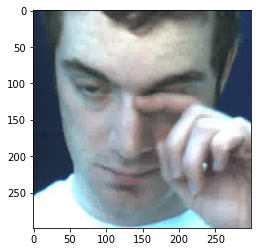

In [64]:
bbox_less = disfa_labels[~disfa_labels['has_bbox']]
im = plt.imread(bbox_less['dest_path'].iloc[10])
plt.imshow(im)

In [47]:
def closest_bbox(x):
    frame = x['frame']
    print(frame)
    video = x['video']
    video_df = disfa_labels.loc[disfa_labels['video'] == video]
    found = False
    i = 1
    current_frame = frame - i
    while (current_frame > 0) and (not(found)):
        current_frame_row = video_df.loc[video_df['frame'] == current_frame].iloc[0]
        found = current_frame_row['has_bbox']
        i += 1
        current_frame = frame - i
    return current_frame_row['bbox']
    

In [50]:
bbox_less = disfa_labels[~disfa_labels['has_bbox']]
bbox_less['bbox'] = bbox_less.progress_apply(closest_bbox, axis=1)


  5%|██                                       | 24/475 [00:00<00:01, 231.30it/s]

804
805
806
807
808
809
810
811
812
813
814
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764

 16%|██████▍                                  | 74/475 [00:00<00:02, 191.62it/s]


1765
1766
1767
1768
1769
1770
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1045
1046
3903
3904
3905
3464
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131


 20%|████████▏                                | 95/475 [00:00<00:02, 161.71it/s]

4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168


 24%|█████████▌                              | 113/475 [00:00<00:03, 115.05it/s]

4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179


 27%|██████████▉                              | 127/475 [00:01<00:04, 86.79it/s]

4180
4181
4182
4183
4184
4185
4186
4187
4188


 29%|███████████▉                             | 138/475 [00:01<00:04, 68.88it/s]

4189
4190
4191
4192
4193
4194
4195
4196


 31%|████████████▋                            | 147/475 [00:01<00:05, 57.89it/s]

4197
4198
4199
4200
4201
4202
4203
4204


 32%|█████████████▎                           | 154/475 [00:01<00:06, 50.60it/s]

4205
4206
4207
4208
4209
4210
4211


 34%|█████████████▊                           | 160/475 [00:02<00:06, 45.10it/s]

4212
4213
4214
4215
4216
4217


 35%|██████████████▏                          | 165/475 [00:02<00:07, 40.92it/s]

4218
4219
4220
4221
4222
4223
4224


 37%|███████████████                          | 174/475 [00:02<00:08, 34.34it/s]

4225
4226
4227
4228
4229
4230


 37%|███████████████▎                         | 178/475 [00:02<00:09, 31.84it/s]

4231
4232
4233
4234
4235
4236


 39%|███████████████▉                         | 185/475 [00:03<00:10, 28.26it/s]

4237
4238
4239
4240
4241


 40%|████████████████▏                        | 188/475 [00:03<00:10, 26.85it/s]

4242
4243
4244
4245
4246


 41%|████████████████▋                        | 194/475 [00:03<00:11, 24.19it/s]

4247
4248
4249
4250
4251


 42%|█████████████████▎                       | 200/475 [00:03<00:12, 22.75it/s]

4252
4253
4254
4255
4256


 43%|█████████████████▌                       | 203/475 [00:03<00:12, 22.01it/s]

4257
4258
4259
4260
4261


 44%|██████████████████                       | 209/475 [00:04<00:13, 20.39it/s]

4262
4263
4264
4265


 45%|██████████████████▎                      | 212/475 [00:04<00:13, 19.79it/s]

4266
4267
4268
4269


 45%|██████████████████▋                      | 216/475 [00:04<00:13, 18.93it/s]

4270
4271
4272
4273


 46%|██████████████████▉                      | 220/475 [00:04<00:13, 18.42it/s]

4274
4275
4276
4277


 47%|███████████████████▎                     | 224/475 [00:05<00:14, 17.90it/s]

4278
4279
4280
4281


 48%|███████████████████▋                     | 228/475 [00:05<00:14, 17.17it/s]

4282
4283
4284
4285


 49%|████████████████████                     | 232/475 [00:05<00:14, 16.73it/s]

4286
4287
4288
4289


 50%|████████████████████▎                    | 236/475 [00:05<00:14, 16.32it/s]

4290
4291
4292
4293


 51%|████████████████████▋                    | 240/475 [00:05<00:14, 16.02it/s]

4294
4295
4296
4297


 51%|█████████████████████                    | 244/475 [00:06<00:14, 15.48it/s]

4298
4299
4300
4301


 52%|█████████████████████▍                   | 248/475 [00:06<00:14, 15.25it/s]

4302
4303
4304


 53%|█████████████████████▊                   | 252/475 [00:06<00:14, 15.07it/s]

4305
4306
4307


 53%|█████████████████████▉                   | 254/475 [00:06<00:14, 14.98it/s]

4308
4309
4310


 54%|██████████████████████                   | 256/475 [00:07<00:14, 14.85it/s]

4311
4312
4313


 55%|██████████████████████▍                  | 260/475 [00:07<00:14, 14.36it/s]

4314
4315
4316


 55%|██████████████████████▌                  | 262/475 [00:07<00:14, 14.30it/s]

4317
4318
4319


 56%|██████████████████████▉                  | 266/475 [00:07<00:14, 14.17it/s]

4320
4321
4322


 56%|███████████████████████▏                 | 268/475 [00:07<00:14, 14.04it/s]

4323
4324
4325


 61%|█████████████████████████▏               | 292/475 [00:08<00:02, 61.30it/s]

4329
4331
4332
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363


 66%|██████████████████████████▉              | 312/475 [00:08<00:02, 71.15it/s]

4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377


 67%|███████████████████████████▌             | 320/475 [00:08<00:02, 66.81it/s]

4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388


 71%|████████████████████████████▉            | 335/475 [00:08<00:02, 55.48it/s]

4389
4390
4391
4392
4393
4394
4395
4396
4397


 72%|█████████████████████████████▍           | 341/475 [00:09<00:02, 50.60it/s]

4398
4399
4400
4401
4402
4403
4404
4405


 73%|█████████████████████████████▉           | 347/475 [00:09<00:02, 45.55it/s]

4406
4407
4408
4409
4410
4411
4412


 75%|██████████████████████████████▊          | 357/475 [00:09<00:03, 38.79it/s]

4413
4414
4415
4416
4417
4418
4419


 76%|███████████████████████████████▏         | 362/475 [00:09<00:03, 36.68it/s]

4420
4421
4422
4423
4424
4425
4426


 78%|███████████████████████████████▉         | 370/475 [00:09<00:03, 32.80it/s]

4427
4428
4429
4430
4431
4432


 79%|████████████████████████████████▎        | 374/475 [00:10<00:03, 31.03it/s]

4433
4434
4435
4436
4437
4438


 80%|████████████████████████████████▉        | 381/475 [00:10<00:03, 28.08it/s]

4439
4440
4441
4442
4443
4444


 81%|█████████████████████████████████▍       | 387/475 [00:10<00:03, 26.10it/s]

4445
4446
4447
4448
4449


 83%|█████████████████████████████████▉       | 393/475 [00:10<00:03, 24.95it/s]

4450
4451
4452
4453
4454


 83%|██████████████████████████████████▏      | 396/475 [00:10<00:03, 24.26it/s]

4455
4456
4457
4458
4459


 85%|██████████████████████████████████▋      | 402/475 [00:11<00:03, 22.64it/s]

4460
4461
4462
4463
4464


 86%|███████████████████████████████████▏     | 408/475 [00:11<00:03, 21.88it/s]

4465
4466
4467
4468
4469


 87%|███████████████████████████████████▍     | 411/475 [00:11<00:03, 21.29it/s]

4470
4471
4472
4473
4474


 88%|███████████████████████████████████▉     | 417/475 [00:12<00:02, 20.50it/s]

4475
4476
4477
4478


 88%|████████████████████████████████████▎    | 420/475 [00:12<00:02, 20.27it/s]

4479
4480
4481
4482


 89%|████████████████████████████████████▌    | 423/475 [00:12<00:02, 19.97it/s]

4483
4484
4485
4486


 90%|████████████████████████████████████▉    | 428/475 [00:12<00:02, 19.30it/s]

4487
4488
4489
4490


 91%|█████████████████████████████████████▎   | 432/475 [00:12<00:02, 18.69it/s]

4491
4492
4493
4494


 92%|█████████████████████████████████████▋   | 436/475 [00:13<00:02, 18.08it/s]

4495
4496
4497
4498


 93%|█████████████████████████████████████▉   | 440/475 [00:13<00:02, 17.21it/s]

4499
4500
4501
4502


 93%|██████████████████████████████████████▎  | 444/475 [00:13<00:01, 16.98it/s]

4503
4504
4505
4506


 94%|██████████████████████████████████████▋  | 448/475 [00:13<00:01, 16.63it/s]

4507
4508
4509
4510


 95%|███████████████████████████████████████  | 452/475 [00:14<00:01, 16.24it/s]

4511
4512
4513
4514


 96%|███████████████████████████████████████▎ | 456/475 [00:14<00:01, 15.85it/s]

4515
4516
4517
4518


 97%|███████████████████████████████████████▋ | 460/475 [00:14<00:00, 15.51it/s]

4519
4520
4521
4522


 98%|████████████████████████████████████████ | 464/475 [00:14<00:00, 15.25it/s]

4523
4524
4525
4526


 99%|████████████████████████████████████████▍| 468/475 [00:15<00:00, 14.96it/s]

4527
4528
4529


 99%|████████████████████████████████████████▌| 470/475 [00:15<00:00, 14.65it/s]

4530
4531
4532


100%|████████████████████████████████████████▉| 474/475 [00:15<00:00, 14.43it/s]

4533
4534
4535


100%|█████████████████████████████████████████| 475/475 [00:15<00:00, 30.36it/s]

4536



/tmp/ipykernel_44882/2690744021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_less['bbox'] = bbox_less.progress_apply(closest_bbox, axis=1)


In [52]:
bbox_less.progress_apply(resize_crop_and_save(299, 72), axis=1)

100%|████████████████████████████████████████| 475/475 [00:04<00:00, 102.75it/s]


5648      None
5649      None
5650      None
5651      None
5652      None
5653      None
5654      None
5655      None
5656      None
5657      None
5658      None
40499     None
40500     None
40501     None
40502     None
40503     None
40504     None
40505     None
40506     None
40507     None
40508     None
40509     None
40510     None
40511     None
40512     None
40513     None
40514     None
40515     None
40516     None
40517     None
40518     None
40519     None
40520     None
40521     None
40522     None
40523     None
40524     None
40525     None
40526     None
40527     None
40528     None
40529     None
83385     None
83386     None
83387     None
83388     None
83389     None
83390     None
83391     None
83392     None
83393     None
83394     None
83395     None
83396     None
83397     None
83398     None
83399     None
83400     None
83401     None
83407     None
83408     None
95955     None
95956     None
95957     None
105206    None
115554    None
115555    

In [36]:
"""

pd.set_option('display.max_rows', 8)
pd.set_option('display.max_colwidth', None)

disfa_labels['video'].unique()
fold0_video = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fold1_video = [10, 11, 12, 13, 16, 17, 18, 21, 23]
fold2_video = [24, 25, 26, 27, 28, 29, 30, 31, 32]

def fold_assignement(video):
    if video in fold0_video:
        return 0
    elif video in fold1_video:
        return 1
    else:
        return 2
    
disfa_labels['fold'] = disfa_labels['video'].map(fold_assignement)

disfa_labels


DISFA_LABEL_PATH = os.path.join(DISFA_PATH, 'preprocessed', '299x299', 'classic_folds', 'fold{}.csv')



fold0 = disfa_labels[disfa_labels['fold'] == 0].filter(regex='AU|path')
fold0 = fold0.rename(columns={'dest_path': 'path'}).drop(columns=['src_path'])

fold1 = disfa_labels[disfa_labels['fold'] == 1].filter(regex='AU|path')
fold1 = fold1.rename(columns={'dest_path': 'path'}).drop(columns=['src_path'])

fold2 = disfa_labels[disfa_labels['fold'] == 2].filter(regex='AU|path')
fold2 = fold2.rename(columns={'dest_path': 'path'}).drop(columns=['src_path'])


fold12 = pd.concat([fold1, fold2], axis=0)
fold02 = pd.concat([fold0, fold2], axis=0)
fold01 = pd.concat([fold0, fold1], axis=0)

fold0.to_csv(DISFA_LABEL_PATH.format("0"), index=False)
fold1.to_csv(DISFA_LABEL_PATH.format("1"), index=False)
fold2.to_csv(DISFA_LABEL_PATH.format("2"), index=False)

fold12.to_csv(DISFA_LABEL_PATH.format("12"), index=False)
fold02.to_csv(DISFA_LABEL_PATH.format("02"), index=False)
fold01.to_csv(DISFA_LABEL_PATH.format("01"), index=False)

"""





In [13]:
import cv2

def align_crop_opencv(img,
                      src_landmarks,
                      standard_landmarks,
                      crop_size=512,
                      face_factor=0.7,
                      align_type='similarity',
                      order=3,
                      mode='edge'):
    """Align and crop a face image by landmarks.
    Arguments:
        img                : Face image to be aligned and cropped.
        src_landmarks      : [[x_1, y_1], ..., [x_n, y_n]].
        standard_landmarks : Standard shape, should be normalized.
        crop_size          : Output image size, should be 1. int for (crop_size, crop_size)
                             or 2. (int, int) for (crop_size_h, crop_size_w).
        face_factor        : The factor of face area relative to the output image.
        align_type         : 'similarity' or 'affine'.
        order              : The order of interpolation. The order has to be in the range 0-5:
                                 - 0: INTER_NEAREST
                                 - 1: INTER_LINEAR
                                 - 2: INTER_AREA
                                 - 3: INTER_CUBIC
                                 - 4: INTER_LANCZOS4
                                 - 5: INTER_LANCZOS4
        mode               : One of ['constant', 'edge', 'symmetric', 'reflect', 'wrap'].
                             Points outside the boundaries of the input are filled according
                             to the given mode.
    """
    # set OpenCV
    inter = {0: cv2.INTER_NEAREST, 1: cv2.INTER_LINEAR, 2: cv2.INTER_AREA,
             3: cv2.INTER_CUBIC, 4: cv2.INTER_LANCZOS4, 5: cv2.INTER_LANCZOS4}
    border = {'constant': cv2.BORDER_CONSTANT, 'edge': cv2.BORDER_REPLICATE,
              'symmetric': cv2.BORDER_REFLECT, 'reflect': cv2.BORDER_REFLECT101,
              'wrap': cv2.BORDER_WRAP}

    # check
    assert align_type in ['affine', 'similarity'], 'Invalid `align_type`! Allowed: %s!' % ['affine', 'similarity']
    assert order in [0, 1, 2, 3, 4, 5], 'Invalid `order`! Allowed: %s!' % [0, 1, 2, 3, 4, 5]
    assert mode in ['constant', 'edge', 'symmetric', 'reflect', 'wrap'], 'Invalid `mode`! Allowed: %s!' % ['constant', 'edge', 'symmetric', 'reflect', 'wrap']

    # crop size
    if isinstance(crop_size, (list, tuple)) and len(crop_size) == 2:
        crop_size_h = crop_size[0]
        crop_size_w = crop_size[1]
    elif isinstance(crop_size, int):
        crop_size_h = crop_size_w = crop_size
    else:
        raise Exception('Invalid `crop_size`! `crop_size` should be 1. int for (crop_size, crop_size) or 2. (int, int) for (crop_size_h, crop_size_w)!')

    # estimate transform matrix
    trg_landmarks = standard_landmarks * max(crop_size_h, crop_size_w) * face_factor + np.array([crop_size_w // 2, crop_size_h // 2])
    if align_type == 'affine':
        tform = cv2.estimateAffine2D(trg_landmarks, src_landmarks, ransacReprojThreshold=np.Inf)[0]
    else:
        tform = cv2.estimateAffinePartial2D(trg_landmarks, src_landmarks, ransacReprojThreshold=np.Inf)[0]

    # warp image by given transform
    output_shape = (crop_size_h, crop_size_w)
    img_crop = cv2.warpAffine(img, tform, output_shape[::-1], flags=cv2.WARP_INVERSE_MAP + inter[order], borderMode=border[mode])

    # get transformed landmarks
    tformed_landmarks = cv2.transform(np.expand_dims(src_landmarks, axis=0), cv2.invertAffineTransform(tform))[0]

    return img_crop, tformed_landmarks

standard_landmarks_face_aligner = os.path.join('..', 'resources', 'Face_aligner', 'standard_landmark_68pts.txt')
landmarks_standard = np.genfromtxt(standard_landmarks_face_aligner).reshape(68, 2)

def load_align_and_save(x):
    src_img = cv2.imread(x['src_path'])
    dest_path = x['dest_path']
    landmarks = np.load(x['landmarks'])
    dest_image, tformed_landmarks = align_crop_opencv(src_img,
                                                      src_landmarks=landmarks,
                                                      standard_landmarks=landmarks_standard,
                                                      face_factor=0.9,
                                                      crop_size=160)
    cv2.imwrite(dest_path, dest_image)
    return True

# disfa_labels.progress_apply(load_align_and_save, axis=1)
disfa_labels.progress_apply(load_align_and_save, axis=1)


    
    


100%|██████████| 125841/125841 [52:16<00:00, 40.13it/s] 


0         True
1         True
2         True
3         True
4         True
          ... 
125836    True
125837    True
125838    True
125839    True
125840    True
Length: 125841, dtype: bool

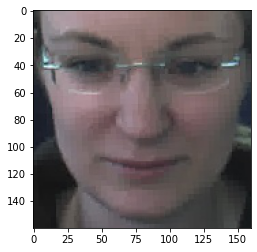

In [25]:


test = disfa_labels.iloc[45000]
test_img = plt.imread(test['dest_path'])
plt.figure()
plt.imshow(test_img)



(68, 2)


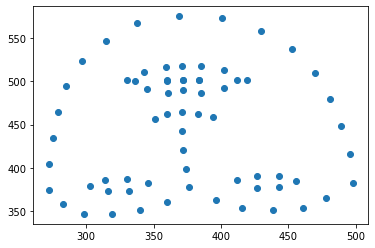

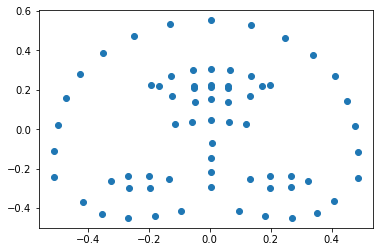

In [12]:
standard_landmarks_face_aligner = os.path.join('..', 'resources', 'Face_aligner', 'standard_landmark_68pts.txt')
landmarks_standard = np.genfromtxt(standard_landmarks_face_aligner).reshape(68, 2)
print(landmarks_standard.shape)

plt.figure()
plt.scatter(test_landmarks[:, 0], test_landmarks[:, 1])

plt.figure()
plt.scatter(landmarks_standard[:, 0], landmarks_standard[:, 1])

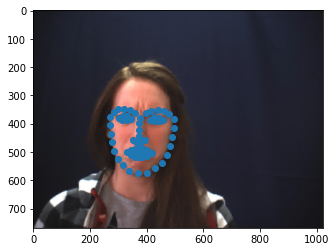

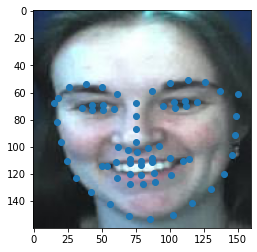

In [9]:


n = 10000
test = disfa_labels.iloc[n]
image = plt.imread(test['path'])
landmarks = np.load(test['landmarks'])



plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1])
plt.show()
 

In [6]:
import processing.face as face

video_numbers = [5]
for video_number in video_numbers:
    video_frames = disfa_labels[disfa_labels['video'] == video_number]
    video_src = src_video_template.format(video_number)
    video_dest = dest_video_template.format(video_number)
    if not(os.path.exists(video_dest)):
        os.makedirs(video_dest)
    frames = (video_frames['frame'].sort_values()
              .map(format_frame)).to_list()

    face.video_face_crop(video=frames,
                         video_src_path=video_src,
                         video_dest_path=video_dest,
                         padding=(0.1, 0.1),
                      
                      target_size=(160, 160))


  0%|          | 0/4845 [00:00<?, ?it/s]

100%|██████████| 4845/4845 [31:51<00:00,  2.53it/s]


In [13]:
def update_path(path):
    split_path = path.split('/')
    split_path[-4] = '299x299'
    return os.path.join(*split_path)
    
    


fold_combinations = ["0", "1", "2", "01", "02", "12"]
DISFA_NEW_LABEL_PATH = os.path.join(DISFA_PATH, 'preprocessed', '299x299', 'folds', 'fold{}.csv')
for fold_combination in fold_combinations:
    fold_path = DISFA_LABEL_PATH.format(fold_combination)
    fold_df = pd.read_csv(fold_path)
    fold_df['path'] = fold_df['path'].map(update_path)
    fold_df.to_csv(DISFA_NEW_LABEL_PATH.format(fold_combination), index=False)
    

In [52]:
fold_to_subfold = ['01', '02', '12']
subfolds = ['0', '1', '2']
subfolds_combination = ['01', '02', '12']


subfold_dfs = []
for fold in fold_to_subfold:
    fold_path = DISFA_LABEL_PATH.format(fold)
    fold_df = pd.read_csv(fold_path)

    video_list = fold_df['video'].unique()
    
    subfold0_video = video_list[:6]
    subfold0_df = fold_df.loc[fold_df['video'].isin(subfold0_video)]
    subfold0_df = subfold0_df.drop(labels=['video', 'frame'], axis=1)
    subfold0_df.to_csv(DISFA_LABEL_PATH.format(fold + '-0'), index=False)

    subfold1_video = video_list[6:12]
    subfold1_df = fold_df.loc[fold_df['video'].isin(subfold1_video)]
    subfold1_df = subfold1_df.drop(labels=['video', 'frame'], axis=1)
    subfold1_df.to_csv(DISFA_LABEL_PATH.format(fold + '-1'), index=False)

    subfold2_video = video_list[12:]
    subfold2_df = fold_df.loc[fold_df['video'].isin(subfold2_video)]
    subfold2_df = subfold2_df.drop(labels=['video', 'frame'], axis=1)
    subfold2_df.to_csv(DISFA_LABEL_PATH.format(fold + '-2'), index=False)
    
    subfold01_df = pd.concat([subfold0_df, subfold1_df], axis=0)
    subfold01_df.to_csv(DISFA_LABEL_PATH.format(fold + '-01'), index=False)
    
    subfold02_df = pd.concat([subfold0_df, subfold2_df], axis=0)
    subfold02_df.to_csv(DISFA_LABEL_PATH.format(fold + '-02'), index=False)
    
    subfold12_df = pd.concat([subfold1_df, subfold2_df], axis=0)
    subfold12_df.to_csv(DISFA_LABEL_PATH.format(fold + '-12'), index=False)

In [39]:
import imutils
import dlib
import cv2
import pandas as pd

fold0 = pd.read_csv(DISFA_LABEL_PATH.format("0"))



def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def landmark_detectorv1(face_detector, landmark_predictor):
    def detect_landmarks(image):
        rects = face_detector(image, 1)
        if len(rects) < 1:
            return False, None 
        rect = rects[0]
        shape = shape_to_np(landmark_predictor(image, rect))
        return True, shape
    return detect_landmarks

def landmarks_from_path(path):
    splits = path.split('/')
    splits[-3] = 'landmarks'
    splits[-1] = splits[-1].split('.')[0] + '.npy'
    return '/'.join(splits)


shape_predictor_path = os.path.join('..', 'resources', 'pretrained_face_predictor', 'shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
landmark_predictor_v1 = landmark_detectorv1(detector, predictor)

fold0['landmarks'] = fold0['path'].map(landmarks_from_path)
fold0['exists'] = fold0['landmarks'].map(lambda x: os.path.exists(x))
exist_fold0 = fold0[~fold0['exists']]
image = plt.imread(exist_fold0.iloc[1]['path'])

plt.imshow(image)
landmarks = landmark_predictor_v1(image)[1]
print(landmarks)
plt.scatter(landmarks[:, 0], landmarks[:, 1])
plt.show()

IndexError: single positional indexer is out-of-bounds

[79.5 72. ]


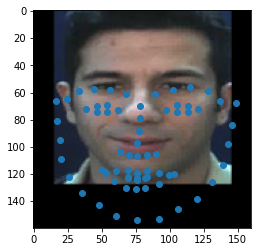

In [60]:
def align_faces(img, landmarks, desired_left_eye, desired_size):
    
    left_eye = np.arange(36, 42)
    right_eye = np.arange(42, 48)
    
    # (2, )
    landmarks_left_eye = np.mean(landmarks[left_eye, :], axis=0)
    # (2, )
    landmarks_right_eye = np.mean(landmarks[right_eye, :], axis=0)
    
    # (2, )
    delta = landmarks_right_eye - landmarks_left_eye
    angle = np.degrees(np.arctan2(delta[1], delta[0]))
    dist = np.linalg.norm(delta, ord=2)
    
    # desired_right_eye_x = 1.0 - self.desired_left_eye[0]
    desired_dist = (1 - 2 * desired_left_eye[0]) * desired_size
    scale = desired_dist / dist
    
    eye_center = (landmarks_left_eye + landmarks_right_eye) / 2
    print(eye_center)
    M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
    new_eye_center = np.matmul(M, np.concatenate([eye_center, [1]]))
    
    tX = 0.5 * desired_size
    tY = desired_size * desired_left_eye[1]
    M[0, 2] += (tX - eye_center[0])
    M[1, 2] += (tY - eye_center[1])
    
    # M[0, 2] = 0
    # M[1, 2] = 0 
    
    (w, h) = (desired_size, desired_size)
    output = cv2.warpAffine(img, M, (w, h),
                            flags=cv2.INTER_CUBIC)
    return output


"""
def read_align_save(src_path, dest_path, landmarks):
    image = cv2.imread(src_path)
    faceAligned = align_faces(image, landmarks, desired_left_eye=(0.35, 0.35), desired_size=160)
    return cv2.imwrite(dest_path, faceAligned)

def apply_align_save(x):
    landmarks_path 
"""

test_x = disfa_labels.iloc[1785]
image = plt.imread(test_x['path'])
landmarks = np.load(test_x['landmarks'])

plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1])

plt.imshow(align_faces(image, landmarks, desired_left_eye=(0.35, 0.35), desired_size=160))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


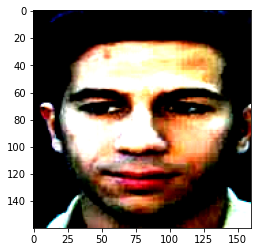

In [62]:
from datasets.disfa.generation import gen_disfa_v2
import tensorflow as tf

sub_disfa = gen_disfa_v2(folds=[0, 1], n_au=8, batchsize=32, mode='train').take(1)

for (image, label) in sub_disfa:
    image0 = image[0].numpy()
    tf.print(label)
    
plt.imshow(image0)

# Result study

[[0.13458249 0.1444512  0.15500644 0.16318442 0.159674   0.13229623
  0.07887586 0.03046358]
 [0.12391114 0.08988372 0.06732623 0.05785561 0.06152868 0.08036759
  0.1439832  0.37671375]
 [0.10795681 0.09915709 0.09694052 0.10281564 0.12610696 0.16582459
  0.18048054 0.1240754 ]
 [0.11167771 0.10262306 0.09584935 0.09431695 0.10848826 0.15434092
  0.18029194 0.15440199]
 [0.15637155 0.19494332 0.19838682 0.17894645 0.14091185 0.0869335
  0.03553495 0.00724728]
 [0.13311607 0.14230876 0.15937826 0.17133127 0.16545527 0.13208781
  0.06942189 0.02589504]
 [0.13401502 0.1443892  0.15407513 0.16191913 0.157539   0.13635238
  0.08212218 0.02661129]
 [0.0983693  0.08224328 0.07303691 0.0696309  0.08029601 0.11179746
  0.22928965 0.2545918 ]]


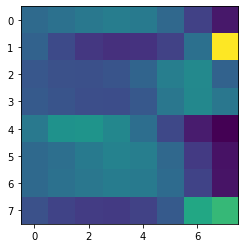

   AUC_ROCAU1  AUC_ROCAU2  AUC_ROCAU4  AUC_ROCAU6  AUC_ROCAU9  AUC_ROCAU12  \
0    0.541952    0.513010    0.396978    0.493723    0.596321     0.479112   
1    0.702086    0.615926    0.818988    0.810276    0.831017     0.965367   
2    0.771423    0.586548    0.797838    0.757596    0.838445     0.929249   
3    0.734803    0.635205    0.777701    0.791274    0.857214     0.937624   
4    0.760924    0.609521    0.812119    0.775669    0.774260     0.955881   
5    0.760591    0.608680    0.811677    0.776318    0.773847     0.956055   

   AUC_ROCAU25  AUC_ROCAU26  mean_AUC_ROC  
0     0.516286     0.462924      0.500038  
1     0.984681     0.856929      0.823159  
2     0.977984     0.878908      0.817249  
3     0.981336     0.873425      0.823573  
4     0.979365     0.877831      0.818196  
5     0.979320     0.877378      0.817983  


In [49]:

EXPERIMENT_FOLD_TEMPLATE = os.path.join('..', 'experiments', 'CVPR_submission', 'disfa', 'fold{}.json')
experiment_file = EXPERIMENT_FOLD_TEMPLATE.format('2')
with open(experiment_file) as json_file:
    experiment_dict = json.load(json_file)
experiment = exp.MetaExperimentParser(experiment_dict)
storing_path = experiment.get_storing_path()
result_df = pd.read_csv(storing_path, header=[0, 1])

max_f1score = result_df.loc[result_df['result', 'mean_f1score'] == result_df['result', 'mean_f1score'].max()].iloc[0]
print(np.load(max_f1score['result', 'softorder_matrix']))
plt.imshow(np.load(max_f1score['result', 'softorder_matrix']))
plt.show()

print(result_df['result'].filter(regex=("AUC.*")))

In [65]:
import seaborn as sns
tracking_df =  pd.read_csv(result_df['meta', 'tracking'].iloc[0])
print(tracking_df.columns)


epoch = 10
epoch0_df = tracking_df.loc[tracking_df['epoch'] == epoch].iloc[0]
th_df = pd.read_csv(epoch0_df['test_f1score_full'], index_col='thresholds')
index_threshold = th_df.index.to_numpy()
threshold_values = th_df.to_numpy()
best_threshold = index_threshold[np.argmax(threshold_values, axis=0)]
print(best_threshold)

Index(['train_tree_perm', 'test_f1score_AU1', 'test_f1score_AU2',
       'test_f1score_AU4', 'test_f1score_AU6', 'test_f1score_AU9',
       'test_f1score_AU12', 'test_f1score_AU25', 'test_f1score_AU26',
       'test_mean_f1score', 'test_th%mean_f1score', 'test_f1score_full',
       'test_accuracy_AU1', 'test_accuracy_AU2', 'test_accuracy_AU4',
       'test_accuracy_AU6', 'test_accuracy_AU9', 'test_accuracy_AU12',
       'test_accuracy_AU25', 'test_accuracy_AU26', 'test_mean_accuracy',
       'test_th%mean_accuracy', 'test_accuracy_full',
       'test_entropy_permutation_matrix', 'epoch'],
      dtype='object')
[0.44499999 0.375      0.58999997 0.85499996 0.73499995 0.50999999
 0.45999998 0.465     ]


[[0.12058927 0.10844571 0.10260651 0.10401475 0.11388244 0.13208462
  0.15718421 0.16325268]
 [0.13088247 0.16229734 0.18293978 0.17799777 0.15157077 0.10812161
  0.05987842 0.02324102]
 [0.12003781 0.11148234 0.10191127 0.09709682 0.0978651  0.10696736
  0.12651229 0.23793447]
 [0.12897636 0.12905283 0.12688555 0.13234438 0.1350935  0.13195854
  0.1438262  0.07396732]
 [0.12023424 0.10674776 0.10148121 0.1004976  0.10880056 0.1212052
  0.13963333 0.20168482]
 [0.12053345 0.1223028  0.13651754 0.1457104  0.14534837 0.13284749
  0.10692243 0.0890788 ]
 [0.12860036 0.13723731 0.13300098 0.1303344  0.13470224 0.14131312
  0.12273148 0.07134832]
 [0.13014604 0.12243418 0.11465755 0.11200364 0.11273687 0.12550163
  0.14331177 0.13949208]]


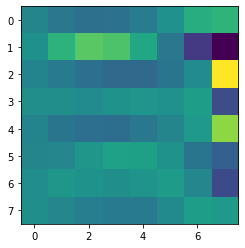

       result                                                               \
  f1score_AU1 f1score_AU2 f1score_AU4 f1score_AU6 f1score_AU9 f1score_AU12   
0    0.086271    0.046678    0.245721    0.085153    0.045953     0.190081   
1    0.578634    0.531783    0.766759    0.411813    0.560895     0.683239   
2    0.691192    0.592517    0.820612    0.429613    0.695441     0.633337   
3    0.695744    0.590631    0.821559    0.426998    0.691033     0.635153   

                                          
  f1score_AU25 f1score_AU26 mean_f1score  
0     0.399596     0.214424     0.164235  
1     0.927176     0.552292     0.626574  
2     0.949919     0.540727     0.669170  
3     0.949060     0.539689     0.668733  


In [66]:
EXPERIMENT_FOLD_TEMPLATE = os.path.join('..', 'experiments', 'CVPR_submission', 'disfa', 'fold{}.json')
experiment_file = EXPERIMENT_FOLD_TEMPLATE.format('0')
with open(experiment_file) as json_file:
    experiment_dict = json.load(json_file)
experiment = exp.MetaExperimentParser(experiment_dict)
storing_path = experiment.get_storing_path()
result_df = pd.read_csv(storing_path, header=[0, 1])

max_f1score = result_df.loc[result_df['result', 'mean_f1score'] == result_df['result', 'mean_f1score'].max()].iloc[0]
print(np.load(max_f1score['result', 'softorder_matrix']))
plt.imshow(np.load(max_f1score['result', 'softorder_matrix']))
plt.show()

print(result_df.filter(regex=("f1score.*")))

In [14]:
EXPERIMENT_FOLD_TEMPLATE = os.path.join('..', 'experiments', 'CVPR_submission', 'disfa', 'fold{}.json')

storing_paths = []
for i in ['0', '1', '2']:
    with open(EXPERIMENT_FOLD_TEMPLATE.format(i)) as json_file:
        experiment_dict = json.load(json_file)
    experiment = exp.MetaExperimentParser(experiment_dict)
    storing_paths.append(experiment.get_storing_path())
    
    

result_dfs = [pd.read_csv(storing_path, header=[0, 1])['result', 'mean_f1score'] for storing_path in storing_paths]


In [5]:
import json
import experiment_parser_extended as exp
import numpy as np
import os
import pandas as pd


result_file = os.path.join('..', 'results', 'disfa', 'damonet', 'fold0', 'fold12-2.csv')

result_df = pd.read_csv(result_file, header=[0, 1])
print(result_df['result', 'mean_AUC_ROC'])

ModuleNotFoundError: No module named 'pandas'

(68, 2)


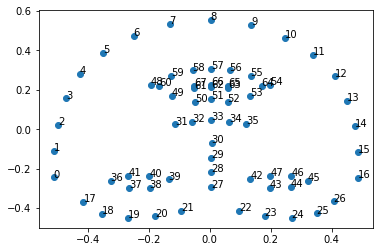

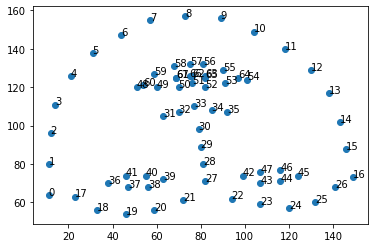

In [78]:
# Face alignement

standard_landmarks_face_aligner = os.path.join('..', 'resources', 'Face_aligner', 'standard_landmark_68pts.txt')
landmarks = np.genfromtxt(standard_landmarks_face_aligner).reshape(68, 2)
print(landmarks.shape)

plt.figure()
plt.scatter(landmarks[:, 0], landmarks[:, 1])
for i in range(landmarks.shape[0]):
    plt.annotate(str(i), [landmarks[i, 0], landmarks[i, 1]])


plt.figure()
landmarks = np.load(disfa_labels.iloc[0]['landmarks'])
plt.scatter(landmarks[:, 0], landmarks[:, 1])
for i in range(landmarks.shape[0]):
    plt.annotate(str(i), [landmarks[i, 0], landmarks[i, 1]])

In [86]:
print(disfa_labels.shape)

def disentangle_landmarks(landmark_path):
    return np.load(landmark_path).ravel()

def project_i(i):
    def fun(x):
        return x[i]
    return fun

# disfa_labels['landmarks_val'] = disfa_labels['landmarks'].map(disentangle_landmarks)
for i in tqdm(range(136)):
    disfa_labels['landmarks_{}'.format(i)] = disfa_labels['landmarks_val'].map(project_i(i))


  0%|          | 0/136 [00:00<?, ?it/s]

(125841, 155)


100%|██████████| 136/136 [00:40<00:00,  3.35it/s]


In [87]:
disfa_landmarks = disfa_labels[['path'] + ['landmarks_{}'.format(i) for i in range(136)]]
disfa_landmarks

path  landmarks_0  \
0       ../resources/DISFA/preprocessed/160x160/images...           11   
1       ../resources/DISFA/preprocessed/160x160/images...           11   
2       ../resources/DISFA/preprocessed/160x160/images...           14   
3       ../resources/DISFA/preprocessed/160x160/images...           15   
4       ../resources/DISFA/preprocessed/160x160/images...           15   
...                                                   ...          ...   
125836  ../resources/DISFA/preprocessed/160x160/images...           20   
125837  ../resources/DISFA/preprocessed/160x160/images...           20   
125838  ../resources/DISFA/preprocessed/160x160/images...           17   
125839  ../resources/DISFA/preprocessed/160x160/images...           18   
125840  ../resources/DISFA/preprocessed/160x160/images...           17   

        landmarks_1  landmarks_2  landmarks_3  landmarks_4  landmarks_5  \
0                64           11           80           12           96   
1                65           11           81           12           96   
2                64           14           80           15           95   
3                65           14           80           15           95   
4                64           14           79           15           93   
...             ...          ...          ...          ...          ...   
125836           73           22           87           25          100   
125837           73           22           87           24          100   
125838           69           19           84           22           98   
125839           71           20           85           23           99   
125840           71           20           85           22           99   

        landmarks_6  landmarks_7  landmarks_8  ...  landmarks_126  \
0                14          111           21  ...             82   
1                14          112           21  ...             82   
2                17          110           24  ...             84   
3                18          110           24  ...             84   
4                17          108           23  ...             82   
...             ...          ...          ...  ...            ...   
125836           27          113           33  ...             91   
125837           27          113           33  ...             91   
125838           25          112           31  ...             90   
125839           26          112           32  ...             90   
125840           25          112           32  ...             90   

        landmarks_127  landmarks_128  landmarks_129  landmarks_130  \
0                 126             97            125             82   
1                 125             97            124             82   
2                 123             99            121             83   
3                 123             99            122             83   
4                 122             98            121             83   
...               ...            ...            ...            ...   
125836            109            111            112             92   
125837            109            110            112             91   
125838            109            109            112             91   
125839            109            107            111             90   
125840            109            107            112             90   

        landmarks_131  landmarks_132  landmarks_133  landmarks_134  \
0                 125             75            126             69   
1                 125             75            125             69   
2                 123             77            123             71   
3                 123             77            124             70   
4                 122             76            123             70   
...               ...            ...            ...            ...   
125836            120             83            121             75   
125837            120            

[[ 11  64]
 [ 11  80]
 [ 12  96]
 [ 14 111]
 [ 21 126]
 [ 31 138]
 [ 44 147]
 [ 57 155]
 [ 73 157]
 [ 89 156]
 [104 149]
 [118 140]
 [130 129]
 [138 117]
 [143 102]
 [146  88]
 [149  73]
 [ 23  63]
 [ 33  56]
 [ 46  54]
 [ 59  56]
 [ 72  61]
 [ 94  62]
 [107  59]
 [120  57]
 [132  60]
 [141  68]
 [ 82  71]
 [ 81  80]
 [ 80  89]
 [ 79  98]
 [ 63 105]
 [ 70 107]
 [ 77 110]
 [ 85 108]
 [ 92 107]
 [ 38  70]
 [ 47  68]
 [ 56  68]
 [ 63  72]
 [ 55  74]
 [ 46  74]
 [ 99  74]
 [107  70]
 [116  71]
 [124  74]
 [116  77]
 [107  76]
 [ 51 120]
 [ 60 120]
 [ 70 120]
 [ 76 122]
 [ 82 120]
 [ 91 122]
 [101 124]
 [ 90 129]
 [ 81 132]
 [ 75 132]
 [ 68 131]
 [ 59 127]
 [ 54 121]
 [ 69 125]
 [ 76 126]
 [ 82 126]
 [ 97 125]
 [ 82 125]
 [ 75 126]
 [ 69 125]]


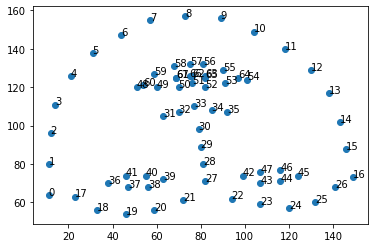

In [92]:
disfa_test = disfa_landmarks[['landmarks_{}'.format(i) for i in range(136)]].values[0, :]
disfa_test = disfa_test.reshape(68, 2)
plt.scatter(disfa_test[:, 0], disfa_test[:, 1])
for i in range(landmarks.shape[0]):
    plt.annotate(str(i), [disfa_test[i, 0], disfa_test[i, 1]])
print(disfa_test)

disfa_test.to_csv('landmarks_disfa.txt', sep=',')




# Result Trombinoscope

In [36]:
from models.interface import get_model
from datasets.disfa.pandas_interface import columns_disfa
from metrics_extended.interface import get_metrics
from datasets.disfa.generation import gen_disfa_v2
import tensorflow as tf
import os

bp4d_model_dict = dict({
    "main": {
        "type": "encoder_regressor",
        "dependencies": [
            "encoder",
            "regressor"
        ]
    },
    "encoder": {
        "type": "inceptionv3_encoder",
        "optimizer": "encoder",
        "pooling": "max",
        "weights": "imagenet"
    },
    "regressor": {
        "type": "imonet",
        "n_task": 8,
        "n_permutations": 512,
        "drop_out": 128,
        "N_sample": 10,
        "label_units": 64,
        "permutation_units": 64,
        "dependencies": [
            "vector"
        ],
        "permutation_heuristic": {
            "type": "random"
        },
        "recurrent_cell_args": {
            "type": "gruv2",
            "units": 64
        },
        "optimizer": "regressor"
    },
    "vector": {
        "type": "vector",
        "n_permutations": 512,
        "optimizer": "permutation"
    }
})

bp4d_metrics_dict = [
    {
        "type": "auc_roc",
        "num_thresholds": 200,
        "pred_in": "global_pred",
        "n_coords": 8
    }
]
bp4d_columns = columns_disfa(n_au=8)
bp4d_eval_metrics = get_metrics(bp4d_metrics_dict, bp4d_columns, log_folder=None)

bp4d_model = get_model(bp4d_model_dict, frequencies=tf.constant(tf.ones((8, ))))
bp4d_model.build((None, 299, 299, 3))
weight_path = os.path.join('..', 'logs', 'CVPR_submission', 'disfa', 'monet_fwbp_bp4d_encoder', 'iv3', 'fold0', '9070',
                           'checkpoints', '2-epoch')
bp4d_model.load_weights(ckpt_path=weight_path,
                        block="main")

entering dataset metric constructor
{'type': 'encoder_regressor', 'encoder': <models.encoders.inception.Inceptionv3 object at 0x7f0b39740670>, 'frequencies': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>}
{'type': 'imonet', 'n_task': 8, 'n_permutations': 512, 'drop_out': 128, 'N_sample': 10, 'label_units': 64, 'permutation_units': 64, 'permutation_heuristic': {'type': 'random'}, 'recurrent_cell_args': {'type': 'gruv2', 'units': 64}, 'vector': <models.vectors.Vector object at 0x7f0b39740760>, 'frequencies': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>}
{'type': 'encoder_regressor', 'encoder': <models.encoders.inception.Inceptionv3 object at 0x7f0b39740670>, 'frequencies': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, 'regressor': <models.regressors.permutation_regressors.monet.ImbalancedMonet object at 0x7f0acc67b310>}


In [65]:
DISFA_LABEL_PATH = os.path.join('..', 'resources', 'DISFA', 'preprocessed', '299x299', 'jaanet_folds', 'fold{}.csv')

print(DISFA_LABEL_PATH.format(0))
fold0_df = pd.read_csv(DISFA_LABEL_PATH.format(0))
fold0_df.head(10)

def extract_video(path):
    path_split = path.split('/')
    return path_split[-2]

fold0_df['video'] = fold0_df['path'].map(extract_video)


df_videos = []
for video in fold0_df['video'].unique():
    # AU_detected_cond = np.logical_or.reduce([fold0_df[au] > 2 for au in bp4d_columns])
    df_video = (fold0_df.loc[(fold0_df['video'] == video)])
    df_videos.append(df_video.sample(5))
    
df_videos = pd.concat(df_videos, axis=0)

../resources/DISFA/preprocessed/299x299/jaanet_folds/fold0.csv


In [69]:
print(df_videos)

       AU12  AU17  AU20  AU26  AU4  AU6  AU15  AU1  AU25  AU2  AU5  AU9  \
886       0     0     0     0    0    0     0    0     0    0    0    0   
3252      0     0     0     0    0    0     0    0     0    0    0    0   
3092      0     1     0     0    0    0     1    0     0    0    0    0   
3245      0     0     0     0    0    0     0    0     0    0    0    0   
1011      0     0     0     0    0    0     0    0     0    0    0    0   
9433      1     0     0     2    0    0     0    0     1    1    0    0   
6120      0     0     0     3    0    0     0    0     1    0    0    0   
5803      2     0     0     2    0    0     0    0     2    0    0    0   
4840      0     0     0     0    0    0     0    0     0    0    0    0   
8169      0     0     0     0    0    0     0    0     0    0    0    0   
11626     0     0     0     0    0    0     0    0     0    0    0    0   
10453     1     0     0     0    0    0     0    0     0    0    0    0   
14106     0     0     0  

In [66]:
predictions = []

for i in range(df_videos.shape[0]):
    dest_image = plt.imread(df.iloc[i]['path']) / 255 
    print(dest_image)
    predictions.append(bp4d_model(np.expand_dims(dest_image, axis=0))['global_pred'])
    
predictions = np.concatenate(predictions, axis=0)
print(predictions.shape)
threshold = np.tile(fold0_threshold, (45, 1))
binary_predictions = (predictions - threshold > 0).astype(float)

[[[0.09803922 0.12156863 0.12156863]
  [0.10196078 0.11764706 0.12156863]
  [0.10588235 0.12156863 0.1254902 ]
  ...
  [0.20392157 0.23921569 0.23529412]
  [0.18431373 0.21960784 0.21568627]
  [0.16470588 0.2        0.19607843]]

 [[0.09019608 0.11372549 0.11372549]
  [0.09803922 0.11372549 0.11764706]
  [0.10980392 0.11372549 0.12156863]
  ...
  [0.20784314 0.24313725 0.23921569]
  [0.19215686 0.22745098 0.22352941]
  [0.18039216 0.21568627 0.21176471]]

 [[0.08627451 0.10980392 0.10980392]
  [0.09411765 0.10980392 0.11372549]
  [0.10588235 0.10980392 0.11764706]
  ...
  [0.21176471 0.24705882 0.24313725]
  [0.19607843 0.23137255 0.22745098]
  [0.18431373 0.21960784 0.21568627]]

 ...

 [[0.08235294 0.09803922 0.10196078]
  [0.08235294 0.09803922 0.10196078]
  [0.07843137 0.09411765 0.09803922]
  ...
  [0.10196078 0.11764706 0.12156863]
  [0.10196078 0.11764706 0.12156863]
  [0.10196078 0.11764706 0.12156863]]

 [[0.08235294 0.09803922 0.10196078]
  [0.08235294 0.09803922 0.10196078]


[[[0.11372549 0.12941176 0.13333333]
  [0.11372549 0.12941176 0.13333333]
  [0.11372549 0.12941176 0.13333333]
  ...
  [0.18431373 0.22352941 0.22745098]
  [0.16470588 0.20392157 0.20784314]
  [0.16862745 0.20784314 0.21176471]]

 [[0.10196078 0.11764706 0.12156863]
  [0.10196078 0.11764706 0.12156863]
  [0.10196078 0.11764706 0.12156863]
  ...
  [0.19215686 0.23137255 0.23529412]
  [0.17254902 0.21176471 0.21568627]
  [0.18039216 0.21960784 0.22352941]]

 [[0.10196078 0.11764706 0.12156863]
  [0.09803922 0.11372549 0.11764706]
  [0.09803922 0.11372549 0.11764706]
  ...
  [0.2        0.23921569 0.24313725]
  [0.18039216 0.21960784 0.22352941]
  [0.19215686 0.23137255 0.23529412]]

 ...

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  ...
  [0.10196078 0.11764706 0.12156863]
  [0.09803922 0.11372549 0.11764706]
  [0.10196078 0.11764706 0.12156863]]

 [[0.09411765 0.09803922 0.10588235]
  [0.09019608 0.09411765 0.10196078]


[[[0.10196078 0.11764706 0.11372549]
  [0.10980392 0.1254902  0.12941176]
  [0.10588235 0.12156863 0.1254902 ]
  ...
  [0.17254902 0.21176471 0.20784314]
  [0.16470588 0.20392157 0.2       ]
  [0.15686275 0.19607843 0.19215686]]

 [[0.10588235 0.12156863 0.11764706]
  [0.10980392 0.1254902  0.12941176]
  [0.10588235 0.12156863 0.1254902 ]
  ...
  [0.20392157 0.24313725 0.23921569]
  [0.20392157 0.24313725 0.23921569]
  [0.18039216 0.21960784 0.21568627]]

 [[0.10588235 0.12156863 0.11764706]
  [0.10980392 0.1254902  0.12941176]
  [0.10588235 0.12156863 0.1254902 ]
  ...
  [0.20784314 0.24705882 0.24313725]
  [0.20392157 0.24313725 0.23921569]
  [0.16862745 0.20784314 0.20392157]]

 ...

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  ...
  [0.10196078 0.11764706 0.12156863]
  [0.09803922 0.11372549 0.11764706]
  [0.09803922 0.11372549 0.11764706]]

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]


[[[0.09803922 0.1372549  0.13333333]
  [0.10196078 0.13333333 0.14117647]
  [0.10980392 0.12941176 0.14117647]
  ...
  [0.2        0.23921569 0.23529412]
  [0.16470588 0.20392157 0.2       ]
  [0.15294118 0.19215686 0.18823529]]

 [[0.09803922 0.1372549  0.13333333]
  [0.10588235 0.1372549  0.14509804]
  [0.10980392 0.12941176 0.14117647]
  ...
  [0.21568627 0.25490196 0.25098039]
  [0.20392157 0.24313725 0.23921569]
  [0.21176471 0.25098039 0.24705882]]

 [[0.10196078 0.14117647 0.1372549 ]
  [0.10588235 0.1372549  0.14509804]
  [0.10980392 0.12941176 0.14117647]
  ...
  [0.20784314 0.24705882 0.24313725]
  [0.20784314 0.24705882 0.24313725]
  [0.21960784 0.25882353 0.25490196]]

 ...

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  ...
  [0.10980392 0.11372549 0.12156863]
  [0.10588235 0.10980392 0.11764706]
  [0.10588235 0.10980392 0.11764706]]

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]


[[[0.10588235 0.1254902  0.1372549 ]
  [0.11372549 0.13333333 0.14509804]
  [0.11764706 0.13333333 0.1372549 ]
  ...
  [0.17254902 0.21960784 0.21960784]
  [0.17254902 0.21960784 0.21960784]
  [0.18039216 0.22745098 0.22745098]]

 [[0.10588235 0.1254902  0.1372549 ]
  [0.11372549 0.13333333 0.14509804]
  [0.11764706 0.13333333 0.1372549 ]
  ...
  [0.19215686 0.23921569 0.23921569]
  [0.18823529 0.23529412 0.23529412]
  [0.18823529 0.23529412 0.23529412]]

 [[0.10588235 0.1254902  0.1372549 ]
  [0.11764706 0.13333333 0.14509804]
  [0.11764706 0.13333333 0.1372549 ]
  ...
  [0.2        0.24705882 0.24705882]
  [0.19607843 0.24313725 0.24313725]
  [0.19215686 0.23921569 0.23921569]]

 ...

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  ...
  [0.10196078 0.11764706 0.12156863]
  [0.10588235 0.12156863 0.1254902 ]
  [0.10588235 0.12156863 0.1254902 ]]

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]


[[[0.10588235 0.12941176 0.11372549]
  [0.10588235 0.12941176 0.12156863]
  [0.12156863 0.14117647 0.15294118]
  ...
  [0.19607843 0.22745098 0.23529412]
  [0.18039216 0.21960784 0.22352941]
  [0.16862745 0.20784314 0.21176471]]

 [[0.11372549 0.13333333 0.11764706]
  [0.10980392 0.13333333 0.1254902 ]
  [0.12156863 0.14117647 0.15294118]
  ...
  [0.20784314 0.23921569 0.24705882]
  [0.19607843 0.23529412 0.23921569]
  [0.18039216 0.21960784 0.22352941]]

 [[0.11372549 0.13333333 0.11764706]
  [0.10588235 0.12941176 0.12156863]
  [0.11764706 0.1372549  0.14901961]
  ...
  [0.22352941 0.25490196 0.2627451 ]
  [0.19607843 0.23529412 0.23921569]
  [0.16862745 0.20784314 0.21176471]]

 ...

 [[0.08627451 0.10196078 0.10588235]
  [0.08627451 0.10196078 0.10588235]
  [0.08627451 0.10196078 0.10588235]
  ...
  [0.10588235 0.12156863 0.1254902 ]
  [0.10588235 0.12156863 0.13333333]
  [0.10588235 0.12156863 0.13333333]]

 [[0.08627451 0.10196078 0.10588235]
  [0.08627451 0.10196078 0.10588235]


[[[0.10980392 0.1254902  0.16862745]
  [0.11372549 0.1254902  0.14509804]
  [0.12156863 0.12941176 0.1254902 ]
  ...
  [0.17647059 0.22352941 0.22352941]
  [0.16862745 0.21568627 0.21568627]
  [0.16078431 0.20784314 0.20784314]]

 [[0.10980392 0.1254902  0.16862745]
  [0.11372549 0.1254902  0.14509804]
  [0.12156863 0.12941176 0.1254902 ]
  ...
  [0.20784314 0.25490196 0.25490196]
  [0.2        0.24705882 0.24705882]
  [0.18039216 0.22745098 0.22745098]]

 [[0.10196078 0.12941176 0.16078431]
  [0.11372549 0.1254902  0.14509804]
  [0.1254902  0.13333333 0.12941176]
  ...
  [0.21176471 0.25882353 0.25882353]
  [0.19215686 0.23921569 0.23921569]
  [0.17254902 0.21960784 0.21960784]]

 ...

 [[0.08235294 0.09803922 0.10196078]
  [0.08627451 0.10196078 0.10588235]
  [0.08627451 0.10196078 0.10588235]
  ...
  [0.10196078 0.11764706 0.12156863]
  [0.10980392 0.11372549 0.12156863]
  [0.11372549 0.11764706 0.1254902 ]]

 [[0.08235294 0.09803922 0.10196078]
  [0.08627451 0.10196078 0.10588235]


[[[0.12941176 0.12156863 0.17254902]
  [0.11372549 0.11764706 0.1372549 ]
  [0.12156863 0.14117647 0.1254902 ]
  ...
  [0.20784314 0.24705882 0.25098039]
  [0.19607843 0.23529412 0.23921569]
  [0.16862745 0.20784314 0.21176471]]

 [[0.12156863 0.11372549 0.16470588]
  [0.11372549 0.11764706 0.1372549 ]
  [0.11764706 0.1372549  0.12156863]
  ...
  [0.20392157 0.24313725 0.24705882]
  [0.20392157 0.24313725 0.24705882]
  [0.18431373 0.22352941 0.22745098]]

 [[0.10980392 0.10980392 0.15686275]
  [0.10980392 0.11372549 0.13333333]
  [0.11372549 0.13333333 0.11764706]
  ...
  [0.2        0.23921569 0.24313725]
  [0.20392157 0.24313725 0.24705882]
  [0.18431373 0.22352941 0.22745098]]

 ...

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]
  ...
  [0.10588235 0.12156863 0.1254902 ]
  [0.10588235 0.12156863 0.1254902 ]
  [0.10196078 0.11764706 0.12156863]]

 [[0.09019608 0.09411765 0.10196078]
  [0.09019608 0.09411765 0.10196078]


In [67]:
print(binary_predictions)

[[1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 

# Results

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import pandas as pd
from utils import dict_from_json
from experiment_parser_extended import MetaExperimentParser
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


from datasets.bp4d.config import AU_ORDER
sanity_file = os.path.join('..', 'experiments', 'CVPR_submission', 'disfa', '299x299', 'jaanet_folds',
                           'monet', 'sfwp_dice', 'iv1', 'fold0.json')
sanity_dict = dict_from_json(sanity_file)
sanity_experiment = MetaExperimentParser(sanity_dict)

storing_path = sanity_experiment.get_storing_path()
sanity_df = pd.read_csv(storing_path, header=[0, 1])
"""
drop_outs = [16]
lrs = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
epochs = 5 * np.arange(10)
print(drop_outs)

last_experiment_df = sanity_df.loc[sanity_df['meta', 'experiment_id'] == sanity_df['meta', 'experiment_id'].max()].iloc[0]
last_experiment_tracking = pd.read_csv(last_experiment_df['meta', 'tracking'])

fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(20, 20))
for drop_out in drop_outs:
    for i in range(len(lrs)):
        print(lr)
        lr = lrs[i]
        cond = (sanity_df['hp', 'drop_out'] == drop_out) & (sanity_df['hp', 'lr1_permutation'] == lr)
        experiment_df = sanity_df.loc[cond].iloc[0]
        experiment_tracking = pd.read_csv(experiment_df['meta', 'tracking'])
        for j in range(len(epochs)):
            epoch = epochs[j]
            epoch_df = experiment_tracking.loc[experiment_tracking['epoch'] == epoch].iloc[0]
            print(epoch_df)
            soft_order_matrix = np.load(epoch_df['train_permutation_matrix'])
            # soft_order_matrix = np.load(epoch_df['result', 'softorder_matrix'])
            axes[j][i].imshow(soft_order_matrix, vmin=0, vmax=1)

plt.show()
"""
# experiment_df = sanity_df.loc[sanity_df['meta', 'experiment_id'] == 9070].iloc[0]
# tracking_df = pd.read_csv(experiment_df['meta', 'tracking'])
# epoch_row = tracking_df.loc[tracking_df['epoch'] == 2].iloc[0]
# threshold_by_metrics = []
# metric_names = ['f1score']
# for metric_name in metric_names:
    # threshold_by_metrics.append(np.expand_dims(np.load(epoch_row['test_th%mean_' + metric_name]), axis=0      ))
# fold0_threshold = np.concatenate(threshold_by_metrics, axis=0)


# print(last_experiment_tracking.columns)


# last_experiment_tracking_bis = pd.read_csv(last_experiment_df_bis['meta', 'tracking'])


# plt.figure()
# print(last_experiment_tracking.columns)

# sns.lineplot(data=last_experiment_tracking, x='epoch', y='train_fwp_dice', label='dice')
# sns.lineplot(data=last_experiment_tracking, x='epoch', y='train_fwbp_loss', label='bce')

# sns.lineplot(data=last_experiment_tracking, x='epoch', y='train_dropout_jensen_permutation_loss', label='classic_loss')

# plt.figure()
# sns.lineplot(data=last_experiment_tracking, x='epoch', y='train_fbbcep_loss', label='dice')
# sanity_df.filter(regex='(experiment_id|f1score.*|n_perm|drop_out|weight_fwp_dice)')
# sanity_df.filter(regex='(epoch|drop_out|f1score|accuracy|mean_AUC)')
# sns.lineplot(data=pd.concat([sanity_df['hp'], sanity_df['result']], axis=1), x='drop_out', y='mean_f1score')
sanity_df.filter(regex='experiment_id|f1score')

meta     result                                              \
   experiment_id f1scoreAU1 f1scoreAU2 f1scoreAU4 f1scoreAU6 f1scoreAU9   
0           9276   0.111024   0.052067   0.210685   0.085075   0.018317   
1           9276   0.708445   0.654253   0.345985   0.453340   0.511544   
2           9276   0.489535   0.503503   0.735454   0.441505   0.570238   
3           9276   0.698212   0.643704   0.712749   0.380388   0.578641   
4           9276   0.721256   0.615470   0.643184   0.514496   0.554849   
5           9276   0.669349   0.643908   0.563181   0.490934   0.280210   
6           9276   0.706595   0.603960   0.606529   0.488985   0.529412   
7           9276   0.366621   0.546826   0.638327   0.476804   0.486091   
8           9276   0.543069   0.602656   0.508103   0.553819   0.608013   
9           9276   0.589958   0.555278   0.540121   0.502561   0.560549   
10          9276   0.596678   0.590289   0.591363   0.472780   0.425090   
11          9276   0.678403   0.554953   0.698407   0.514436   0.491923   
12          9276   0.647432   0.646258   0.664407   0.521882   0.343793   
13          9276   0.366222   0.558929   0.607756   0.488051   0.641785   
14          9276   0.686630   0.391939   0.627537   0.495979   0.517189   
15          9276   0.665122   0.605892   0.636595   0.504453   0.386720   

                                                     
   f1scoreAU12 f1scoreAU25 f1scoreAU26 mean_f1score  
0     0.190085    0.400764    0.214027     0.160255  
1     0.725143    0.893242    0.480013     0.596496  
2     0.745314    0.797845    0.531117     0.601814  
3     0.724605    0.805322    0.578500     0.640265  
4     0.682945    0.802314    0.524097     0.632326  
5     0.684505    0.883885    0.574836     0.598851  
6     0.667734    0.853808    0.600986     0.632251  
7     0.687522    0.870714    0.660229     0.591642  
8     0.702994    0.862483    0.520004     0.612643  
9     0.759700    0.911979    0.483540     0.612961  
10    0.705591    0.881902    0.524889     0.598573  
11    0.714995    0.910909    0.552513     0.639567  
12    0.712226    0.854035    0.518601     0.613579  
13    0.632979    0.928378    0.472161     0.587033  
14    0.694993    0.869837    0.511774     0.599485  
15    0.682049    0.846367    0.458515     0.598214

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


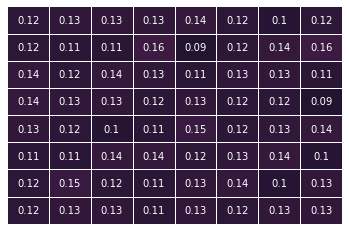

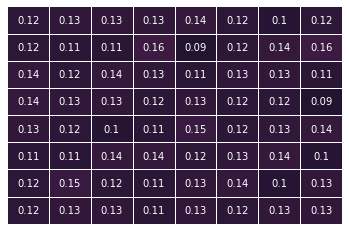

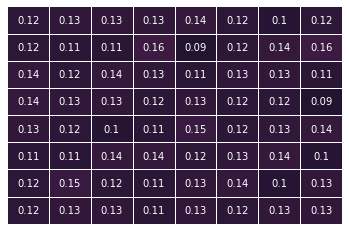

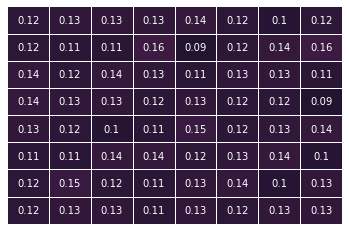

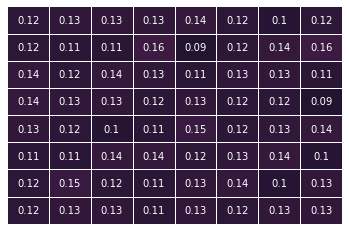

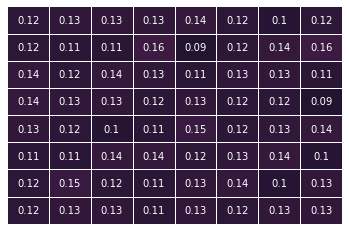

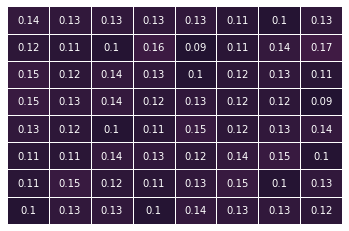

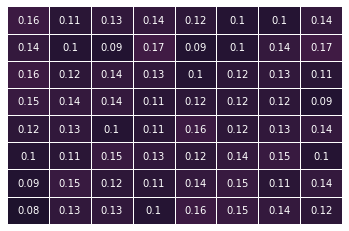

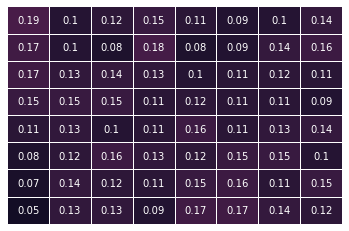

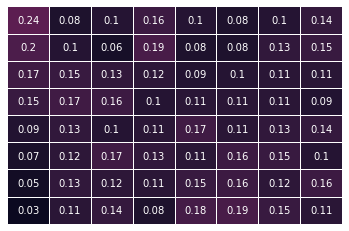

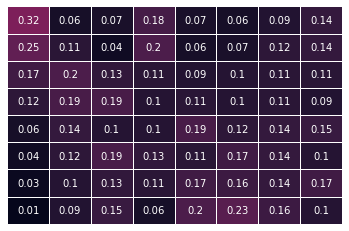

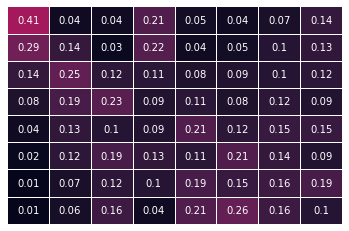

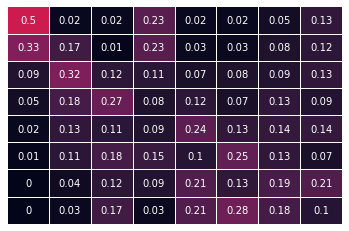

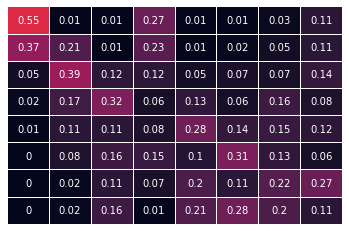

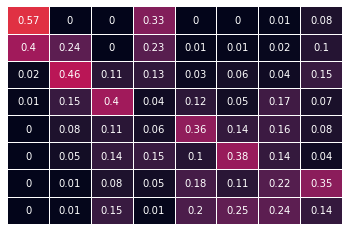

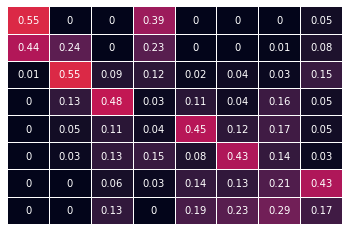

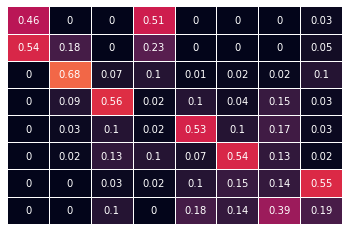

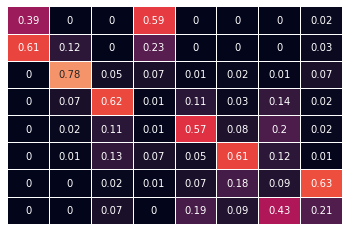

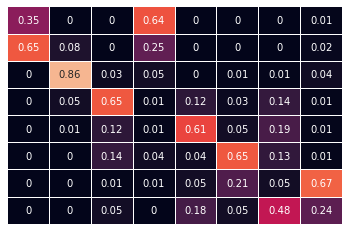

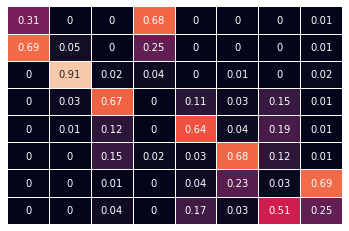

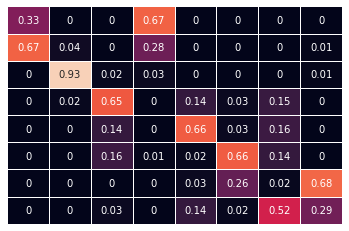

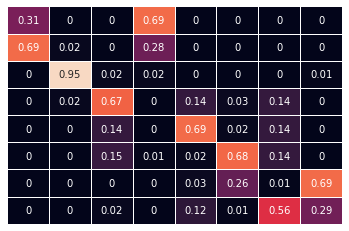

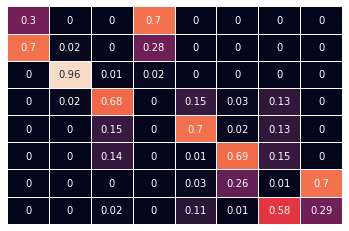

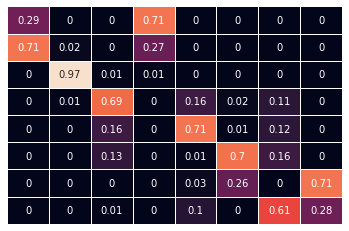

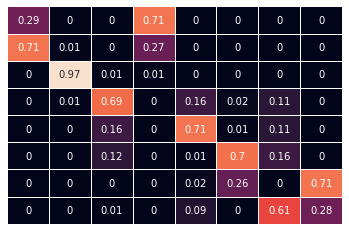

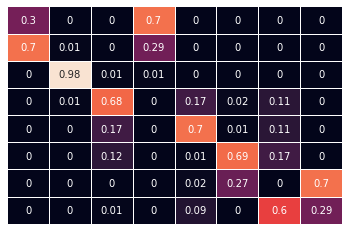

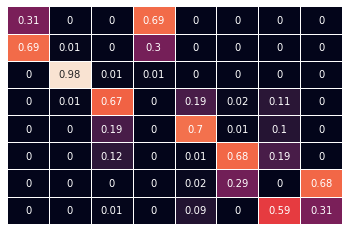

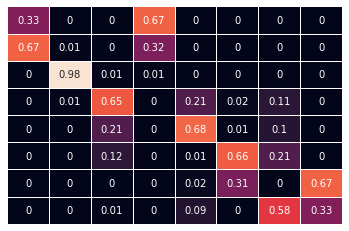

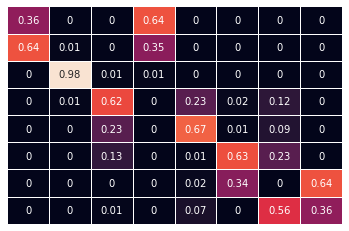

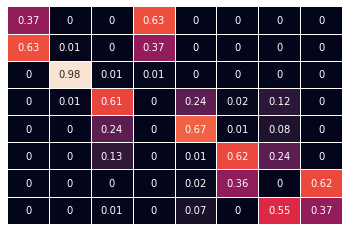

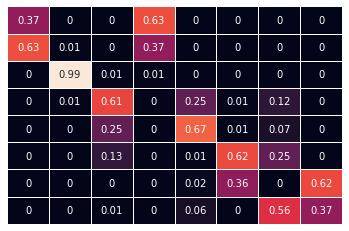

In [75]:
tracking_df = pd.read_csv(sanity_df['meta', 'tracking'].loc[sanity_df['meta', 'experiment_id'] == 9273].iloc[0])

# fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))
epochs = tracking_df['epoch'].unique()
print(epochs)

for i in range(len(epochs)):
    epoch = epochs[i]
    epoch_row = tracking_df[tracking_df['epoch'] == epoch].iloc[0]
    # epoch_row['train_permutation_matrix']
    permutation_matrix = np.load(epoch_row['train_permutation_matrix'])
    plt.figure()
    sns.heatmap(np.round(permutation_matrix, decimals=2),
                cbar=None,
                vmin=0.,
                vmax=1.,
                linewidths=.5,
                annot=True)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('fold0_permutation_matrix_{}.pdf'.format(epoch), bbox_inches='tight')
    
    plt.show()

In [13]:
AUs = ['f1scoreAU{}'.format(au) for au in [1, 2, 4, 6, 9, 12, 25, 26]]

sanity_df['result'][AUs].mean(axis=1)

0    0.411614
1    0.641347
2    0.578033
3    0.558306
4    0.589430
5    0.603240
dtype: float64

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from datasets.disfa.generation import gen_disfa_v2
from dataset_statistics import frequencies


disfa0 = gen_disfa_v2(fold='0', batchsize=16, mode='train', meta=True)
disfa0_frequencies = frequencies(disfa0)

disfa1 = gen_disfa_v2(fold='1', batchsize=16, mode='train', meta=True)
disfa1_frequencies = frequencies(disfa1)

disfa2 = gen_disfa_v2(fold='2', batchsize=16, mode='train', meta=True)
disfa2_frequencies = frequencies(disfa2)

tf.Tensor(
[0.04507773 0.02391211 0.11774637 0.04442261 0.02537355 0.1050218
 0.25033388 0.11983773], shape=(8,), dtype=float32)
tf.Tensor(
[0.03577111 0.02199128 0.15286118 0.08835001 0.02940724 0.15570952
 0.31234282 0.09984604], shape=(8,), dtype=float32)
tf.Tensor(
[0.07244235 0.07349802 0.18204424 0.10308021 0.06962723 0.143266
 0.28179324 0.05709996], shape=(8,), dtype=float32)


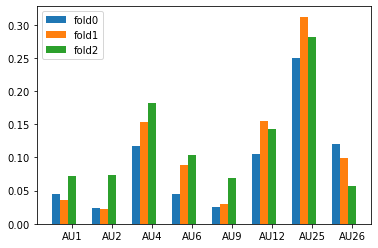

In [19]:
import matplotlib.pyplot as plt
import numpy as np
tick_label = ['AU1', 'AU2', 'AU4', 'AU6', 'AU9', 'AU12', 'AU25', 'AU26']
plt.bar(np.arange(8) - 0.1, disfa0_frequencies, width=0.2, label='fold0', tick_label=tick_label)
plt.bar(np.arange(8) + 0.1, disfa1_frequencies, width=0.2, label='fold1', tick_label=tick_label)
plt.bar(np.arange(8) + 0.3, disfa2_frequencies, width=0.2, label='fold2', tick_label=tick_label)
plt.legend()
print(disfa0_frequencies)
print(disfa1_frequencies)
print(disfa2_frequencies)

In [91]:
import matplotlib.pyplot as plt
import numpy as np
tick_label = ['AU1', 'AU2', 'AU4', 'AU6', 'AU9', 'AU12', 'AU25', 'AU26']
plt.bar(np.arange(8) - 0.1, disfa0_frequencies, width=0.2, label='fold0', tick_label=tick_label)
plt.bar(np.arange(8) + 0.1, disfa1_frequencies, width=0.2, label='fold1', tick_label=tick_label)
plt.bar(np.arange(8) + 0.3, disfa2_frequencies, width=0.2, label='fold2', tick_label=tick_label)
plt.legend()
print(disfa0_frequencies)
print(disfa1_frequencies)
print(disfa2_frequencies)

NameError: name 'disfa0_frequencies' is not defined

In [114]:
from datasets.disfa.pandas_interface import columns_disfa

fold12 = pd.read_csv(DISFA_LABEL_PATH.format('12'))
fold12.head(10)

def extract_video(path):
    return path.split('/')[-2]

def intensity_to_activation(x):
    return float(x >= 2)

fold12['video'] = fold12['path'].map(extract_video)
unique_videos = fold12['video'].unique()
fold12[fold12['AU1'] >=2].shape

col_disfa = columns_disfa(n_au=8)
for au in col_disfa:
    fold12[au] = fold12[au].map(intensity_to_activation)
    

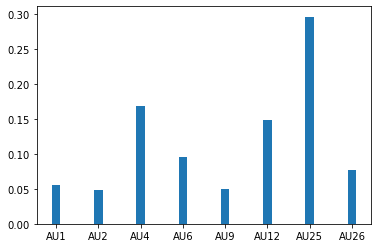

In [116]:
fold12_au = fold12[col_disfa]
frequencies = fold12_au.sum(axis=0)/fold12_au.shape[0]
plt.bar(np.arange(8) - 0.1, frequencies, width=0.2, label='fold0', tick_label=col_disfa)
plt.show()

<BarContainer object of 8 artists>

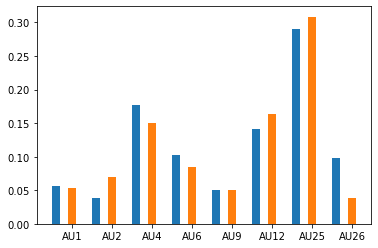

In [128]:
train_videos = unique_videos[:12]
valid_videos = unique_videos[12:]

train_set = fold12[fold12['video'].isin(train_videos)]
train_set.head(10)
train_set_au = train_set[col_disfa]
train_frequencies = train_set_au.sum(axis=0)/train_set_au.shape[0]
train_frequencies

valid_set = fold12[fold12['video'].isin(valid_videos)]
valid_set.head(10)
valid_set_au = valid_set[col_disfa]
valid_frequencies = valid_set_au.sum(axis=0)/valid_set_au.shape[0]
valid_frequencies

plt.bar(np.arange(8) - 0.2, train_frequencies, width=0.2, label='fold0', tick_label=col_disfa)
plt.bar(np.arange(8) + 0.2, valid_frequencies, width=0.2, label='fold0', tick_label=col_disfa)

In [130]:
fold12.head(10)

AU12  AU17  AU20  AU26  AU4  AU6  AU15  AU1  AU25  AU2  AU5  AU9  \
0   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
1   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
2   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
3   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
4   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
5   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
6   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
7   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
8   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   
9   0.0     0     0   0.0  0.0  0.0     0  0.0   0.0  0.0    0  0.0   

                                                                 path  video  
0  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0001.jpg  SN006  
1  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0002.jpg  SN006  
2  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0003.jpg  SN006  
3  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0004.jpg  SN006  
4  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0005.jpg  SN006  
5  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0006.jpg  SN006  
6  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0007.jpg  SN006  
7  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0008.jpg  SN006  
8  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0009.jpg  SN006  
9  ../resources/DISFA/preprocessed/299x299/images/SN006/frame0010.jpg  SN006

In [133]:
fold12 = pd.read_csv(DISFA_LABEL_PATH.format('12'))
fold12['video'] = fold12['path'].map(extract_video)

fold12_12 = fold12[fold12['video'].isin(train_videos)].drop(columns='video')
fold12_0 = fold12[fold12['video'].isin(valid_videos)].drop(columns='video')

In [138]:
fold12_12.to_csv(DISFA_LABEL_PATH.format('12-12'), index=False)
fold12_0.to_csv(DISFA_LABEL_PATH.format('12-0'), index=False)